In [1]:
import torch
from torch import nn
import d2l.torch as d2l  # 动手学深度学习工具包

# 模型参数
n_train, n_test, num_inputs = 20, 100, 200  # 少量训练样本，多特征
true_w, true_b = torch.ones(num_inputs) * 0.01, 0.05

# 合成数据（用于演示过拟合问题）
features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.normal(0, 0.01, labels.shape)  # 添加噪声

# 拆分训练集/测试集
train_features, test_features = features[:n_train], features[n_train:]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [2]:
# 定义 L2 正则化项
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [3]:
# 初始化模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# 定义平方损失函数
def squared_loss(y_hat, y):
    return ((y_hat - y.reshape(y_hat.shape)) ** 2) / 2

In [4]:
# 训练函数（加权重衰减）
def train(lambd):
    w, b = init_params()
    net = lambda X: torch.matmul(X, w) + b  # 线性模型

    num_epochs, lr = 100, 0.003
    batch_size = 1
    train_ls, test_ls = [], []

    for epoch in range(num_epochs):
        for X, y in d2l.load_array((train_features, train_labels), batch_size, is_train=True):
            # 计算原始 loss + 权重惩罚项
            l = squared_loss(net(X), y) + lambd * l2_penalty(w)

            l.sum().backward()
            with torch.no_grad():
                w -= lr * w.grad
                b -= lr * b.grad
                w.grad.zero_()
                b.grad.zero_()

        # 每个 epoch 记录训练和测试误差
        train_ls.append(squared_loss(net(train_features), train_labels).mean().item())
        test_ls.append(squared_loss(net(test_features), test_labels).mean().item())

    return train_ls, test_ls

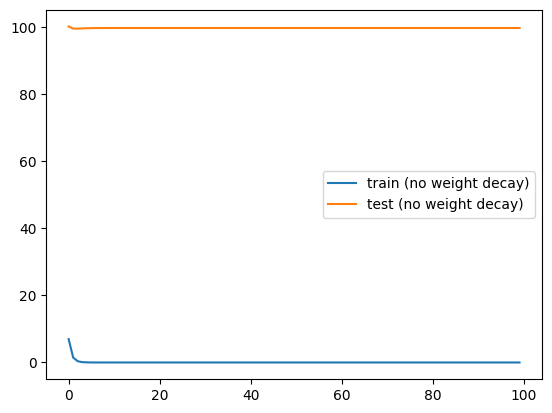

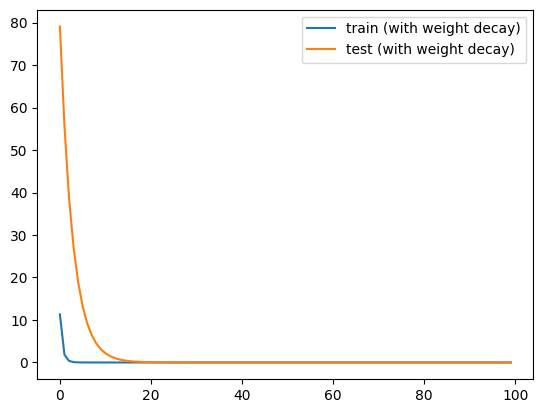

In [5]:
import matplotlib.pyplot as plt

# 不加正则（容易过拟合）
train_ls, test_ls = train(lambd=0)
plt.plot(train_ls, label='train (no weight decay)')
plt.plot(test_ls, label='test (no weight decay)')
plt.legend()
plt.show()

# 加权重衰减（泛化更好）
train_ls2, test_ls2 = train(lambd=3)
plt.plot(train_ls2, label='train (with weight decay)')
plt.plot(test_ls2, label='test (with weight decay)')
plt.legend()
plt.show()